In [51]:
"""pip install scikit-optimize
pip install optuna
pip install fitter"""

'pip install scikit-optimize\npip install optuna\npip install fitter'

In [52]:
#Tratamieto de datos
import pandas as pd 
import numpy as np  
from tabulate import tabulate
# ==============================================================================================================================================================

#   Gráficos 
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
# ==============================================================================================================================================================

#Preprocesado y Modelado
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence
import optuna

# Varios
# ==============================================================================================================================================================
import multiprocessing
import random
from itertools import product
from fitter import Fitter, get_common_distributions
# Configuración matplotlib
# ==============================================================================================================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================================================================================================
import warnings
warnings.filterwarnings('ignore')

# Objetivo

Obtener un modelo capaz de predecir si se rechaza o no un canal de res cárnico

In [53]:
data=pd.read_excel(r"D:\Never Urueta\2023\Algoritmos Tesis\Data.xlsx") 

In [54]:
data1 = data.drop(["PBA", "CF", "CAPACIDAD DEL CUARTO FRIO  ", "Indicador", "VT1", "VT2", "DESTINO"], axis=1)

In [55]:
data1.isnull().sum() #Datos faltantes
data1['Tamin'].fillna(data1['Tamin'].median(), inplace=True)
print("valores perdidos en Tamin: " + 
      str(data1['Tamin'].isnull().sum()))
data1['Taamax'].fillna(data1['Taamax'].median(), inplace=True)
print("valores perdidos en Taamax: " + 
      str(data1['Taamax'].isnull().sum()))

valores perdidos en Tamin: 0
valores perdidos en Taamax: 0


### Variable de Respuesta 

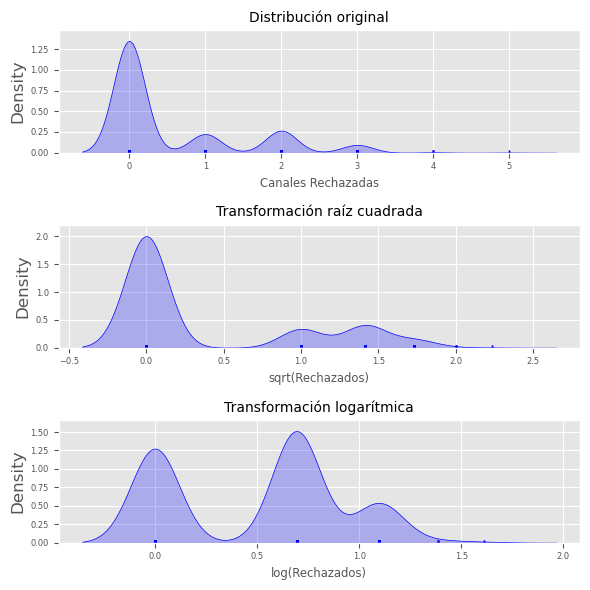

In [56]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
sns.kdeplot(
    data1.Rechazados,
    fill    = True,
    color   = "blue",
    ax      = axes[0]
)
sns.rugplot(
    data1.Rechazados,
    color   = "blue",
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('Canales Rechazadas', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.kdeplot(
    np.sqrt(data1.Rechazados),
    fill    = True,
    color   = "blue",
    ax      = axes[1]
)
sns.rugplot(
    np.sqrt(data1.Rechazados),
    color   = "blue",
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(Rechazados)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.kdeplot(
    np.log(data1.Rechazados),
    fill    = True,
    color   = "blue",
    ax      = axes[2]
)
sns.rugplot(
    np.log(data1.Rechazados),
    color   = "blue",
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(Rechazados)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

### Ditribución de Probabilidad

In [57]:
distribuciones = ['cauchy', 'chi2', 'expon',  'exponpow', 'gamma',
                  'norm', 'powerlaw', 'beta', 'logistic']

fitter = Fitter(data1.Rechazados, distributions=distribuciones)
fitter.fit()
fitter.summary(Nbest=10, plot=False)

Fitting 9 distributions: 100%|██████████| 9/9 [00:01<00:00,  7.98it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,118.627433,1281.607504,-5300.091957,inf,0.694282,0.000000e+00
exponpow,126.073559,585.308791,-5183.571905,inf,0.694357,0.000000e+00
beta,152.240519,437.963608,-4815.042027,inf,0.694357,0.000000e+00
chi2,165.332892,459.363260,-4664.695253,inf,0.694357,0.000000e+00
expon,175.167721,790.640503,-4561.655633,inf,0.694357,0.000000e+00
powerlaw,186.088242,386.602081,-4438.345590,inf,0.694357,0.000000e+00
logistic,197.286140,800.580710,-4334.059515,inf,0.372468,7.643201e-239
norm,198.993160,852.109693,-4317.569848,inf,0.417928,2.322199e-303
cauchy,206.734080,9137.146821,-4244.526105,inf,0.351491,6.050174e-212


### Correlación variables numéricas

De archivo ejecutadon con regresión se evidenció una correlación entre dos variables independientes, por lo que procederemos a eñliminar a una, la variable Ocupación

In [58]:
data1 = data1.drop(["Ocupacion"],axis=1)

### Variabes cualitativas

Eliminamos los registros de PBA2 solo quedandonos con PBA1 

In [59]:
data1 = data1.loc[data1["TIPO_CAP_CF"] != "PBA2", :]

In [60]:
data1.loc[data1["Rechazados"] > 0, "Rechazados"] = 1
print(data1.Rechazados.value_counts().sort_index())

0    1259
1     583
Name: Rechazados, dtype: int64


In [61]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                        data1.drop('Rechazados', axis = 'columns'),
                                        data1['Rechazados'],
                                        train_size   = 0.67,
                                        random_state = 1234,
                                        
                                        shuffle      = True
                                    )

In [62]:
print("Partición de entrenamento")
print("-----------------------")
print(y_train.describe())
print("-----------------------")
print("-----------------------")
print("Partición de test")
print("-----------------------")
print(y_test.describe())

Partición de entrenamento
-----------------------
count    1234.000000
mean        0.321718
std         0.467325
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Rechazados, dtype: float64
-----------------------
-----------------------
Partición de test
-----------------------
count    608.000000
mean       0.305921
std        0.461176
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Rechazados, dtype: float64


## Modelo

### K-Nearest Neighbor (kNN)

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold


# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')


# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', KNeighborsClassifier())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro
param_distributions = {
    'modelo__n_neighbors': range(1, 21, 2),
    'modelo__weights': ['uniform', 'distance'],
    'modelo__metric'   : ['euclidean', 'manhattan', 'minkowski'],
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3), 
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )


grid.fit(X = X_train, y = y_train) 

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__weights,param_modelo__n_neighbors,param_modelo__metric,mean_test_score,std_test_score,mean_train_score,std_train_score
1,distance,19,manhattan,0.680983,0.026296,1.0,0.0


In [64]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score


# Error de test del modelo final
# ==============================================================================
knn_model = grid.best_estimator_
predicciones0 = knn_model.predict(X = X_test)
Accuracy_knn = accuracy_score(y_true  = y_test, y_pred  = predicciones0)
print(f"Accuracy_knn: {Accuracy_knn}")

RMSE_knn = mean_squared_error(y_true  = y_test, y_pred  = predicciones0, sample_weight = X_test["Ti1"],squared = False)
print(f"RMSE: {RMSE_knn}")

Accuracy_knn: 0.7154605263157895
RMSE: 0.5336849077979466


### Regresión lineal (Ridge y Lasso)¶

In [65]:
from sklearn.linear_model import RidgeClassifier

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', RidgeClassifier())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro
param_distributions = {'modelo__alpha': np.logspace(-5, 5, 500),
                       'modelo__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'lbfgs']}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3), 
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__solver,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
11,lsqr,18.730315,0.680443,0.028219,0.69091,0.010216


In [66]:
# Error de test del modelo final
# ==============================================================================
ridge_model = grid.best_estimator_
predicciones1 = ridge_model.predict(X = X_test)
Accuracy_ridge= accuracy_score(y_true  = y_test, y_pred  = predicciones1)
print(f"Accuracy: {Accuracy_ridge}")

RMSE_ridge = mean_squared_error(y_true  = y_test, y_pred  = predicciones1, squared = False)
print(f"RMSE: {RMSE_ridge}")

Accuracy: 0.712171052631579
RMSE: 0.5364969220493451


### Regresión Logística

In [67]:

from sklearn.linear_model import LogisticRegression

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo',  LogisticRegression())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__solver': ['newton-cg', 'lbfgs', 'liblinear', 'newton-cholesky'],
    'modelo__penalty': ['l1', 'l2', 'elasticnet'],
    'modelo__C'   : [100, 10, 1.0, 0.1, 0.01],
}



# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3), 
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__solver,param_modelo__penalty,param_modelo__C,mean_test_score,std_test_score,mean_train_score,std_train_score
7,newton-cg,l2,0.1,0.67934,0.034891,0.689626,0.00899


In [68]:
# Error de test del modelo final
# ==============================================================================
lr_model = grid.best_estimator_
predicciones2 = lr_model.predict(X = X_test)
Accuracy_lr= accuracy_score(y_true  = y_test, y_pred  = predicciones2)
print(f"Accuracy: {Accuracy_lr}")

RMSE_lr = mean_squared_error(y_true  = y_test, y_pred  = predicciones2, squared = False)
print(f"RMSE: {RMSE_lr}")

Accuracy: 0.7088815789473685
RMSE: 0.5395539093108599


### Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier
# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')


# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', RandomForestClassifier(n_estimators=10))])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [10, 100, 1000,10000],
    'modelo__max_features': ['sqrt', 'log2'],
    'modelo__max_depth'   : [None, 3, 5, 10, 20]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__n_estimators,param_modelo__max_features,param_modelo__max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
4,100,log2,None,0.702353,0.035456,1.0,0.0


In [70]:
# Error de test del modelo final
# ==============================================================================
rf_model = grid.best_estimator_
predicciones3 = rf_model.predict(X = X_test)
Accuracy_rf= accuracy_score(y_true  = y_test, y_pred  = predicciones3)
print(f"Accuracy: {Accuracy_rf}")
RMSE_rf = mean_squared_error(y_true  = y_test, y_pred  = predicciones3, squared = False)
print(f"RMSE: {RMSE_rf}")

Accuracy: 0.7450657894736842
RMSE: 0.5049101014302603


### Gradient Boosting Trees

In [71]:
from sklearn.ensemble import GradientBoostingClassifier

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')


# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', GradientBoostingClassifier())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__loss': ['log_loss', 'deviance', 'exponential'],
    'modelo__n_estimators': [50, 100, 1000, 5000],
    'modelo__max_features': ['auto', 'sqrt', 'log2'],
    'modelo__max_depth'   : [None, 3, 5, 10, 20],
    'modelo__subsample'   : [0.1, 0.5,0.7, 1]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__subsample,param_modelo__n_estimators,param_modelo__max_features,param_modelo__max_depth,param_modelo__loss,mean_test_score,std_test_score,mean_train_score,std_train_score
10,0.7,5000,log2,10,deviance,-0.55162,0.030503,0.0,0.0


In [72]:
gbt_model = grid.best_estimator_
predicciones4 = gbt_model.predict(X = X_test)

Accuracy_gbt= accuracy_score(y_true  = y_test, y_pred  = predicciones4)
print(f"Accuracy: {Accuracy_gbt}")
RMSE_gbt = mean_squared_error(y_true  = y_test, y_pred  = predicciones4, squared = False)
print(f"RMSE: {RMSE_gbt}")

Accuracy: 0.7351973684210527
RMSE: 0.5145897701848992


### Árboles de decisión

In [73]:
from sklearn.tree import DecisionTreeClassifier

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')


# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', DecisionTreeClassifier())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__criterion': ['gini', 'entropy', 'log_loss'],
    'modelo__max_features': ['auto', 'sqrt', 'log2'],
    'modelo__min_samples_split': [1, 2, 10, 500],
    'modelo__max_depth'   : [None, 3, 5, 10, 30, 100, 10000],
    'modelo__max_leaf_nodes'   : [1, 10, 20, 100, 10000],
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train, modelo__sample_weight = X_train["Ti1"])

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__min_samples_split,param_modelo__max_leaf_nodes,param_modelo__max_features,param_modelo__max_depth,param_modelo__criterion,mean_test_score,std_test_score,mean_train_score,std_train_score
16,500,100,auto,10,entropy,-0.569192,0.020623,-0.566277,0.005859


In [74]:
dtree_model = grid.best_estimator_
predicciones5 = gbt_model.predict(X = X_test)

Accuracy_dtree= accuracy_score(y_true  = y_test, y_pred  = predicciones5)
print(f"Accuracy: {Accuracy_dtree}")
RMSE_dtree = mean_squared_error(y_true  = y_test, y_pred  = predicciones5, squared = False)
print(f"RMSE: {RMSE_dtree}")

Accuracy: 0.7351973684210527
RMSE: 0.5145897701848992


### Máquinas de vectores de soporte

In [75]:
from sklearn import svm
from sklearn.svm import NuSVC


# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')


# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo',svm.NuSVC())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__nu': [0, 0.2, 0.5, 1],
    'modelo__kernel' : ['poly', 'rbf', 'sigmoid'],
    'modelo__gamma'   : ['scale', 'auto'],
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__nu,param_modelo__kernel,param_modelo__gamma,mean_test_score,std_test_score,mean_train_score,std_train_score
14,0.5,poly,auto,-0.580289,0.019145,-0.373895,0.011351


In [76]:
svm_model = grid.best_estimator_
predicciones6 = svm_model.predict(X = X_test)

Accuracy_svm= accuracy_score(y_true  = y_test, y_pred  = predicciones6)
print(f"Accuracy: {Accuracy_svm}")
RMSE_svm = mean_squared_error(y_true  = y_test, y_pred  = predicciones6, squared = False)
print(f"RMSE: {RMSE_svm}")

Accuracy: 0.7467105263157895
RMSE: 0.503278723655402


## Stacking

In [81]:
from sklearn.ensemble import StackingClassifier

# Pipeline: preprocesado + modelos para el stacking
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')


# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe_knn = Pipeline([('preprocessing', preprocessor),
                     ('knn', KNeighborsClassifier(weights='distance',n_neighbors=19, metric='manhattan'))])

pipe_ridge = Pipeline([('preprocessing', preprocessor),
                     ('ridge', RidgeClassifier(solver='lsqr',alpha=23.59))])

pipe_lr= Pipeline([('preprocessing', preprocessor),
                     ('Poisson', LogisticRegression(solver='liblinear',penalty='l2',C=0.01))])

pipe_rf = Pipeline([('preprocessing', preprocessor),
                     ('random_forest', RandomForestClassifier(
                                         n_estimators = 100,
                                         max_features = 'log2',
                                         max_depth    = 20
                                        )
                     )])

pipe_gbt = Pipeline([('preprocessing', preprocessor),
                     ('Gradient_Boosting_Trees', GradientBoostingClassifier(
                                         subsample = 0.7,                 
                                         n_estimators = 5000,
                                         max_features = 'log2',
                                         max_depth    = 10,
                                         loss= 'deviance'
                                        )
                     )])

pipe_dtree = Pipeline([('preprocessing', preprocessor),
                     ('Decision_Tree', DecisionTreeClassifier(
                                         min_samples_split = 500,                 
                                         max_leaf_nodes = 100,
                                         max_features = 'auto',
                                         max_depth    = 10,
                                         criterion = 'gini'
                                        )
                     )])

pipe_svm = Pipeline([('preprocessing', preprocessor),
                     ('svm', svm.NuSVC(
                                         nu = 0.5,                 
                                         kernel = 'poly',
                                         gamma  = 'auto'
                                        )
                     )])

In [78]:
# Definición y entrenamiento del StackingClassifier
# ==============================================================================
estimators = [('random_forest', pipe_rf),
              #('knn', pipe_knn),
              ('Gradient_Boosting_Trees', pipe_gbt),
              ('Decision_Tree', pipe_dtree),
              ('svm', pipe_svm)]

stacking_cla= StackingClassifier(estimators=estimators,
                                       final_estimator=LogisticRegression())
# Se asigna el resultado a _ para que no se imprima por pantalla
_ = stacking_cla.fit(X = X_train, y = y_train)

In [82]:
stacking_model = stacking_cla
predicciones7 = stacking_model.predict(X = X_test)

Accuracy_stacking= accuracy_score(y_true  = y_test, y_pred  = predicciones7)
print(f"Accuracy: {Accuracy_stacking}")
RMSE_stacking = mean_squared_error(y_true  = y_test, y_pred  = predicciones7, squared = False)
print(f"RMSE: {RMSE_stacking}")

Accuracy: 0.7582236842105263
RMSE: 0.4917075510803893


Text(0.5, 0, 'Test accuracy')

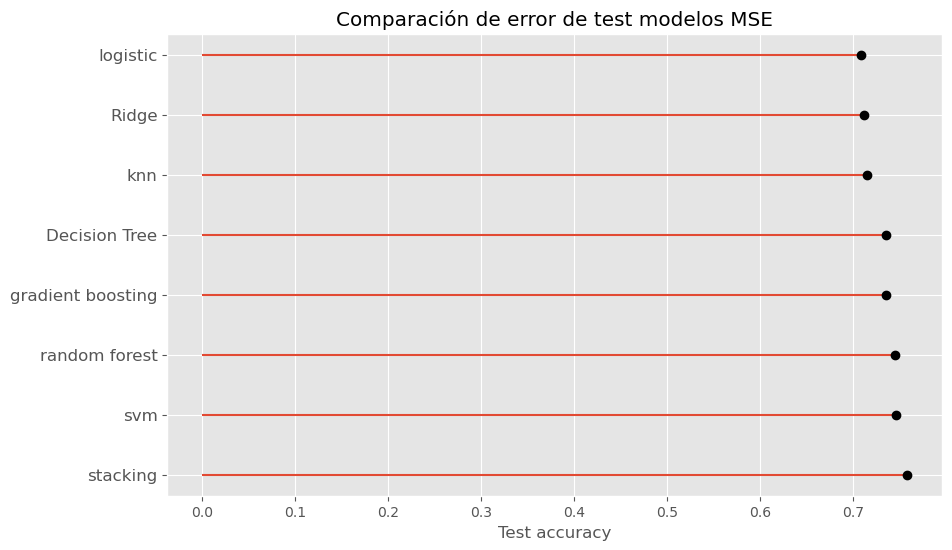

In [83]:
error_modelos = pd.DataFrame({'modelo': ['knn', 'Ridge','logistic' ,'random forest', 'gradient boosting',"Decision Tree", "svm",'stacking'],
                              'MSE': [Accuracy_knn, Accuracy_ridge, Accuracy_lr, Accuracy_rf, Accuracy_gbt, Accuracy_dtree, Accuracy_svm, Accuracy_stacking]})
error_modelos = error_modelos.sort_values('MSE', ascending=False)


plt.figure(figsize=(10, 6))
plt.hlines(error_modelos.modelo, xmin=0, xmax=error_modelos.MSE)
plt.plot(error_modelos.MSE, error_modelos.modelo, "o", color='black')
plt.tick_params(axis='y', which='major', labelsize=12)
plt.title('Comparación de error de test modelos MSE')
plt.xlabel('Test accuracy')

